## 进阶作业：共享单车用户数预测

### 作业要求:
利用美国某共享单车公司2011/2012年数据，训练和测试一个模型，并对模型的性能和预测能力进行测试。

### 批改标准
3. 对全体数据，随机选择其中80%做训练数据，剩下20%为测试数据，评价指标为RMSE。（10分） 
4. 用训练数据训练最小二乘线性回归模型（20分）、岭回归模型、Lasso模型，其中岭回归模型（30分）和Lasso模型（30分），注意岭回归模型和Lasso模型的正则超参数调优。 
5. 比较用上述三种模型得到的各特征的系数，以及各模型在测试集上的性能。并简单说明原因.

### 实现思路
特征工程：

1. 数据探索

 使用pandas查看数据规模、特征维数、特征涵义、特征数据类型；
 查看特征描述统计量、空值数量；
 用直方图、箱体图、提琴图等查看单变量大致分布、是否有噪声数据；
 用相关矩阵热力图、scatter/hue查看两特征之间相关性；

2. 数据预处理
    
    删除冗余、噪音数据；
    处理缺失值；
    数据分离；
    离散型特征编码；
    数值特征标准化；
    
3. 确定模型类型
  
4. 评价性能

## 1.导入必要工具包

In [61]:
import numpy as np #矩阵处理
import pandas as pd #数据处理

from sklearn.metrics import r2_score # 评价回归预测模型的性能

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt #画图
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder # 数据标准化

from scipy.sparse import hstack

# 图形出现在Notebook里而不是新窗口
%matplotlib inline


## 2.数据探索
见文件　CBdata.ipynb

In [62]:
### 2.1 读取数据

In [63]:
# dapath = '/media/wyb/work/AI-learning/ai/week-00/ML-Capital-Bikeshare/dataset/'  # 数据文件路径

cb = pd.read_csv('../dataset/day.csv')  # 以csv格式读取数据

# print "cb　data type is %s" % cb.dtypes  # 输出各字段数据类型

cb.head()  # 打印文件头部内容，查看各字段前五列数据值
# print cb.tail()  # 打印数据尾部五个数据值


# 读取样本数目、特征维数每个特征的类型、空值样本数目、数据类型
cb.shape



(731, 16)

## 2.2 数据准备

In [64]:
y = cb['cnt']

X = cb.drop(['dteday','instant','casual','registered','cnt'],axis=1)

# 训练数据与测试数据8/2分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
# 从训练数据中获取输入特征X和输出特征Y
#y_train = y_train['cnt'].values

#　删除暂时无关特征
# X_train = X_train.drop(['dteday','instant','casual','registered'],axis=1)

# X_test = X_test.drop(['dteday','instant','casual','registered'],axis=1)

# columns = X_test.columns

## 2.3 数据预处理/特征工程

### 2.3.1　数据预处理

In [67]:
OneHotEnc = OneHotEncoder()
mn_x = MinMaxScaler()

# 对训练数据中输入特征x中类别变量进行OneHotEncoder处理
x_train_cat = OneHotEnc.fit_transform(X_train[['season','mnth','holiday','weekday','workingday']])

#　数据值变量继续预处理
x_train_num = mn_x.fit_transform(X_train[['temp','atemp','hum','windspeed']])

# 将变换后的变量合到一起
x_train = hstack((x_train_cat, x_train_num))

# y_train = train_data['cnt'].values



In [68]:
# 对测试数据预处理
x_test_cat = OneHotEnc.transform(X_test[['season','mnth','holiday','weekday','workingday']])
x_test_num = mn_x.transform(X_test[['temp','atemp','hum','windspeed']])
x_test = hstack((x_test_cat, x_test_num))

# y_test = test_data['cnt'].values

### 3.确定模型类型
#### 3.1 尝试缺省参数的最小二乘线性回归

In [95]:
#　线性回归
from sklearn.linear_model import LinearRegression

#使用默认配置初始化
lr = LinearRegression(copy_X=True)

# 训练模型参数
lr.fit(x_train, y_train)

#分别在训练集与测试集预测
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)

# 查看各特征权重，权重绝对值大小为该特征重要程度
# fs = pd.DataFrame({'columns':list((lr.coef_.T)), "coef":list((lr.coef_.T))})
# fs.sort_values(by=['coef'], ascending=False)

# y_test_pred_lr

lr.coef_

array([ -8.39797300e+02,   1.08893550e+02,  -2.34240817e+02,
         7.10602147e+02,   2.94388320e+02,   2.96843135e+02,
         5.56606111e+02,  -9.82832672e+01,   1.19563272e+02,
        -5.32088380e+02,  -1.13626884e+03,  -5.70787252e+02,
         5.18199501e+02,   2.61578610e+02,  -1.02236296e+02,
         1.37942667e+02,   1.03477415e+02,  -3.58019835e+02,
        -1.39289919e+02,  -5.13611737e-01,  -1.49558561e+02,
        -1.31250092e+02,  -1.87377800e+02,   7.74289686e+01,
         2.76018596e+02,  -2.21291159e+02,  -3.32512616e+01,
         5.74166319e+03,   5.07569110e+02,  -4.04187663e+03,
        -1.59773811e+03])

#### 3.1.1 模型评价

In [96]:
# 使用RMSE评价
from sklearn.metrics import mean_squared_error
# 测试集
print 'The RMSE of LinearRegression on test is',mean_squared_error(y_test, y_test_pred_lr)

# 训练集
print 'The RMSE of LinearRegression on train is',mean_squared_error(y_train, y_train_pred_lr)

The RMSE of LinearRegression on test is 1957408.96184
The r2 score of LinearRegression on train is 1561794.26933


## 为什么RMSE值这么大？？

In [71]:
# 使用r2_score评价模型在测试及和训练集上的性能，并输出评估结果
# 测试集
print 'The r2 score of LinearRegression on test is',r2_score(y_test, y_test_pred_lr)

# 训练集
print 'The r2 score of LinearRegression on train is',r2_score(y_train, y_train_pred_lr)

The r2 score of LinearRegression on test is 0.511853760044
The r2 score of LinearRegression on train is 0.573943964507


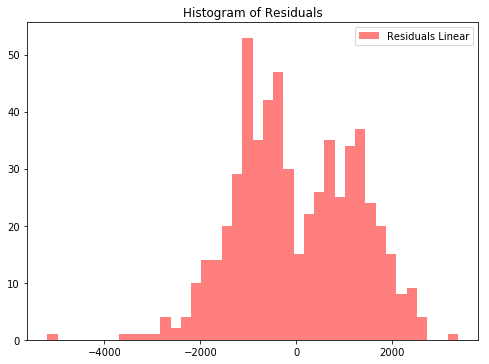

In [72]:
# 在训练集上观测预测残差分布
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(y_train - y_train_pred_lr, bins=40, label="Residuals Linear", color='red', alpha=.5)
ax.set_title("Histogram of Residuals")
ax.legend(loc='best')


### 3.2 Huber损失回归模型

In [73]:
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor()
huber.fit(x_train, y_train)

# 分别在训练集与测试集上预测 
y_train_pred_hb = huber.predict(x_train)
y_test_pred_hb = huber.predict(x_test)


### 3.2.1 模型评价

In [74]:
# 使用r2_score评价模型在测试及和训练集上的性能，并输出评估结果
# 测试集
print 'The r2 score of HuberRegression on test is',r2_score(y_test, y_test_pred_hb)

# 训练集
print 'The r2 score of HuberRegression on train is',r2_score(y_train, y_train_pred_hb)

The r2 score of HuberRegression on test is 0.506130465299
The r2 score of HuberRegression on train is 0.571341411898


## 4.岭回归，对正则参数lambda (scikit learn 中为alpha)调优

In [75]:
from sklearn.linear_model import RidgeCV

#设置超参数范围
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

#生成一个RidgeCV实例
ridge = RidgeCV(alphas = alphas, )

In [76]:
# 模型训练
ridge.fit(x_train, y_train)

RidgeCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [77]:
# 预测
y_test_pred_rg = ridge.predict(x_test)
y_train_pred_rg = ridge.predict(x_train)
print (('the best alpha '), ridge.alpha_)

('the best alpha ', 1.0)


再次优化

In [78]:
ridge = RidgeCV(alphas=np.array([.1, .5, .9, 1.3, 1.7]))
ridge.fit(x_train, y_train)
print (('the best alpha '), ridge.alpha_)

('the best alpha ', 0.90000000000000002)


可视化交叉验证过程

In [79]:
# 提高精确度
alphas_to_test = np.linspace(0.01, 0.9)
rcv = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
rcv.fit(x_train, y_train)

RidgeCV(alphas=array([ 0.01   ,  0.02816,  0.04633,  0.06449,  0.08265,  0.10082,
        0.11898,  0.13714,  0.15531,  0.17347,  0.19163,  0.2098 ,
        0.22796,  0.24612,  0.26429,  0.28245,  0.30061,  0.31878,
        0.33694,  0.3551 ,  0.37327,  0.39143,  0.40959,  0.42776,
        0.44592,  0.46408...5469,
        0.77286,  0.79102,  0.80918,  0.82735,  0.84551,  0.86367,
        0.88184,  0.9    ]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [80]:
rcv.cv_values_.shape

(584, 50)

In [81]:
# 找到最小值
min_idx = rcv.cv_values_.mean(axis=0).argmin()
alphas_to_test[min_idx]

0.73653061224489791

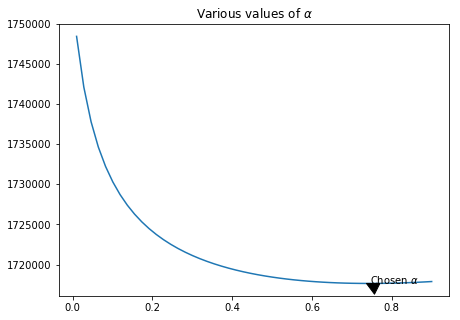

In [82]:
f, ax = plt.subplots(figsize=(7, 5))
ax.set_title(r'Various values of $\alpha$')

xy = (alphas_to_test[min_idx], rcv.cv_values_.mean(axis=0)[min_idx])
xytext = (xy[0] + .01, xy[1] + .1)

ax.annotate(r'Chosen $\alpha$', xy = xy, xytext=xytext,
           arrowprops=dict(facecolor='black', shrink=0, width=0))
ax.plot(alphas_to_test, rcv.cv_values_.mean(axis=0))

In [89]:
# 预测
y_test_pred_rcv = rcv.predict(x_test)
y_train_pred_rcv = rcv.predict(x_train)
print (('the best alpha '), rcv.alpha_)

('the best alpha ', 0.73653061224489791)


In [90]:
# 评估，使用r2_score评价模型在测试集和训练集上的性能
print (('the r2 score of RidgeCV on test is '), r2_score(y_test, y_test_pred_rcv))
print (('the r2 score of RidgeCV on train is '), r2_score(y_train, y_train_pred_rcv))

('the r2 score of RidgeCV on test is ', 0.51688412289876284)
('the r2 score of RidgeCV on train is ', 0.57193343171599187)


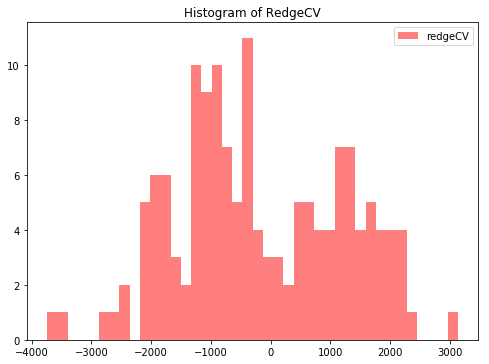

In [91]:
# 在测试集上观测预测残差分布
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(y_test - y_test_pred_rcv, bins=40, label="redgeCV", color='red', alpha=.5)
ax.set_title("Histogram of RedgeCV")
ax.legend(loc='best')

## 5. Lasso 模型

In [92]:
from sklearn.linear_model import LassoCV
#设置超参数范围
alphas = [0.01, 0.1, 1, 10, 100, 1000, 10000]
lasso = LassoCV(alphas=alphas)
# lasso = LassoCV()

In [93]:
lasso.fit(x_train, y_train)

LassoCV(alphas=[0.01, 0.1, 1, 10, 100, 1000, 10000], copy_X=True, cv=None,
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [94]:
y_test_pred_lso = lasso.predict(x_test)
print (('the r2 score of Lasso on train is '), r2_score(y_test, y_test_pred_lso))
print (('the best alpha '), lasso.alpha_)

('the r2 score of Lasso on train is ', 0.52780865379440434)
('the best alpha ', 10.0)


## 超参数调优

In [99]:
lcv = LassoCV(alphas=np.array([9., 10., 11.]))
lcv.fit(x_train, y_train)
print (('the best alpha '), lcv.alpha_)

('the best alpha ', 10.0)


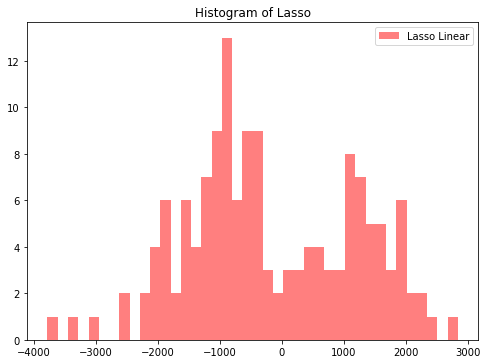

In [88]:
# 在测试集上观测预测残差分布
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(y_test - y_test_pred_lso, bins=40, label="Lasso Linear", color='red', alpha=.5)
ax.set_title("Histogram of Lasso")
ax.legend(loc='best')